In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import pywt
from tqdm import tqdm

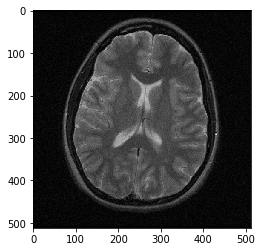

In [2]:
brain_mat = loadmat('brain.mat')
brain_image = np.abs(brain_mat['im'])
plt.imshow(brain_image, cmap='gray')

# I. Sparsity in wavelet spaces

max level for db4 6


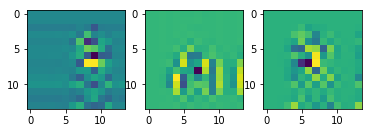

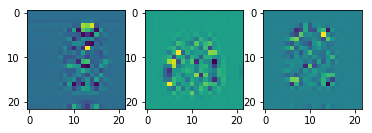

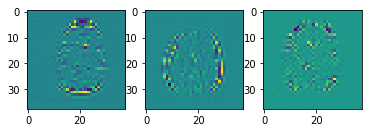

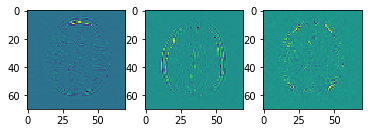

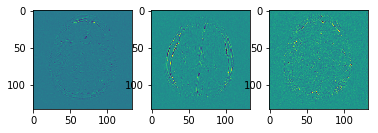

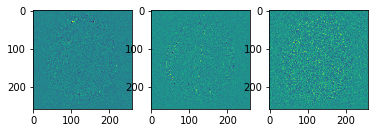

In [3]:
wavelet = 'db4'
image_wt = pywt.wavedec2(brain_image, wavelet)
all_coef = []
for e in image_wt[1:]:
    fig, axes = plt.subplots(1,3)
    for i in range(3):
        axes[i].imshow(e[i])
        all_coef.append(e[i].flatten())

max_level = pywt.dwt_max_level(brain_image.shape[0], pywt.Wavelet(wavelet))        
print('max level for', wavelet, max_level)

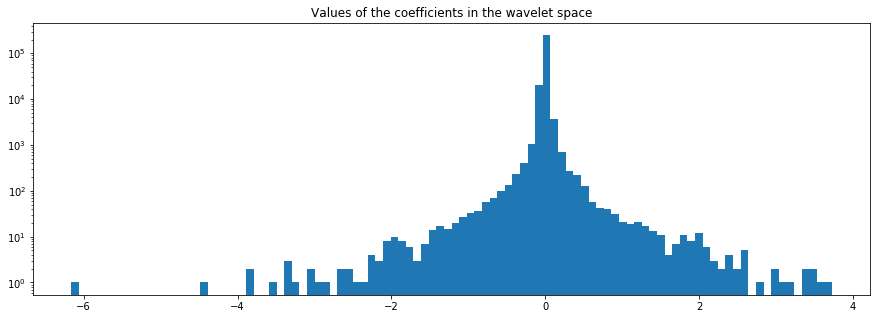

In [4]:
full_coef = np.hstack(all_coef)
plt.figure(figsize=(15,5))
plt.hist(full_coef, log=True, bins=100)
plt.title('Values of the coefficients in the wavelet space')
plt.show()

coef threshold 0.05825739624165659


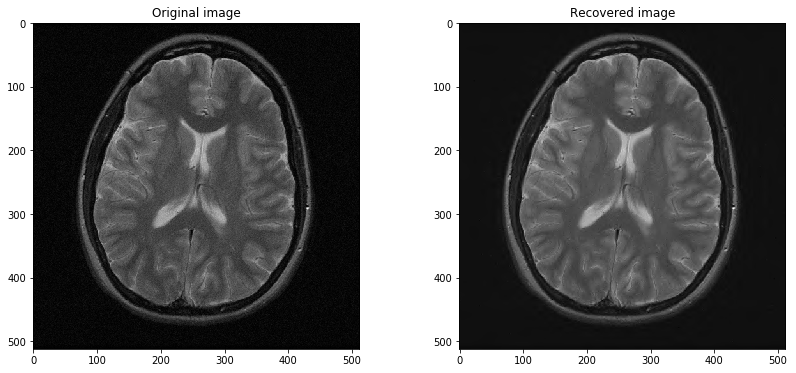

In [5]:
threshold = 0.95
coef_threshold = np.sort(np.abs(full_coef))[int(full_coef.shape[0]*0.95)]
print('coef threshold', coef_threshold)
im0 = np.multiply(image_wt[0], np.abs(image_wt[0])>coef_threshold)
image_shrink = [im0]
for i in range(1,7):
    im1 = np.multiply(image_wt[i][0], np.abs(image_wt[i][0])>coef_threshold)
    im2 = np.multiply(image_wt[i][1], np.abs(image_wt[i][1])>coef_threshold)
    im3 = np.multiply(image_wt[i][2], np.abs(image_wt[i][2])>coef_threshold)
    image_shrink.append((im1, im2, im3))
im_recover = pywt.waverec2(image_shrink, wavelet)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(brain_image, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(im_recover, cmap='gray')
ax2.set_title('Recovered image')
plt.show()

# II. Projection Over a Convex Set algorithm (POCS)
We will now act as if we were in MRI conditions and use compressed sensing to recover the brain image. For that purpose, we suppose that we observe only a subsample of the Fourier coefficients of the brain image (in the frequencies space).

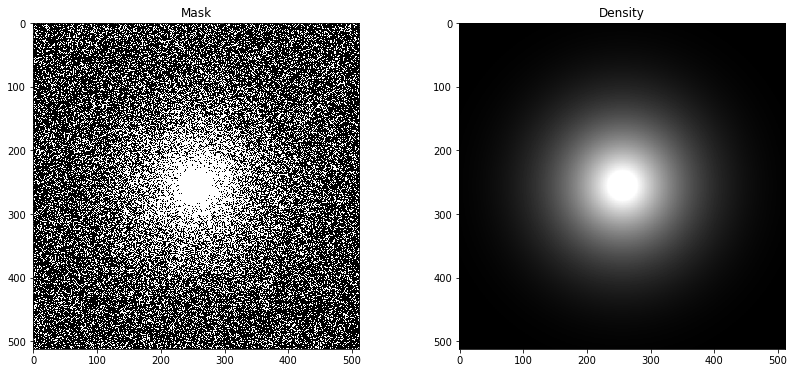

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(brain_mat['mask_vardens'], cmap= 'gray')
ax1.set_title('Mask')
ax2.imshow(brain_mat['pdf_vardens'], cmap= 'gray')
ax2.set_title('Density')
plt.show()

In [7]:
def soft_threshold(y, t):
    x_hat = (y/np.abs(y)) * np.maximum(np.abs(y)-t,0)
    return x_hat

In [8]:
def pocs(kspace_under, mask, num_iter, lambda_value, wavelet='db4'):
    """
    Input: - y: measured coefficients in the Fourier space
           - mask: the mask of the measured coefficients
           - N_iter: number of iterations
           - l: threshold value
    Output: list of rebuild images (at each iteration)
    """
    im_cs = np.fft.ifft2(kspace_under)

    results = [im_cs]
    for i in tqdm(range(num_iter)):
        
        # wavelets + thresholding
        wavelet_im = pywt.wavedec2(im_cs, wavelet)
        
        wavelet_dec = [soft_threshold(wavelet_im[0], lambda_value)]
        for e in wavelet_im[1:]:
            wavelet_dec.append((soft_threshold(e[0], lambda_value), 
                                soft_threshold(e[1], lambda_value), 
                                soft_threshold(e[2], lambda_value)))

        im_cs = pywt.waverec2(wavelet_dec, wavelet)
        
        # projection
        im_cs = np.abs(np.fft.ifft2(np.multiply(np.fft.fft2(im_cs),1-mask) + kspace_under))
        
        # append result
        results.append(np.abs(im_cs))
    
    return results

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.96it/s]


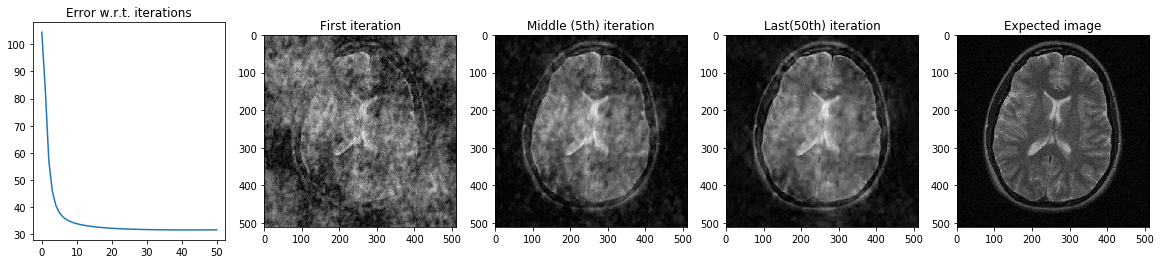

In [9]:
# parameters
mask = brain_mat['mask_vardens']
num_iter = 50
lambda_value = 0.025

# measured coefficients in the k-space
kspace_under = np.multiply(np.fft.fft2(brain_image), mask)
# algorithm
history = pocs(kspace_under, mask, num_iter, lambda_value)

# plots
errors = [np.linalg.norm(brain_image-e) for e in history]
idx_middle = np.where(errors>np.max(errors)/np.e)[0][-1]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(history[0]), cmap='gray')
ax2.set_title('First iteration')
ax3.imshow(np.abs(history[idx_middle]), cmap='gray')
ax3.set_title('Middle (%dth) iteration'%(idx_middle+1))
ax4.imshow(np.abs(history[-1]), cmap='gray')
ax4.set_title('Last(%dth) iteration'%(num_iter))
ax5.imshow(brain_image, cmap='gray')
ax5.set_title('Expected image')
plt.show()

# III. Non-linear Conjugate-Gradient algorithm
Here is the implementation of the algorithm proposed by Lustig et al. in "Sparse MRI: The Application of Compressed Sensing for Rapid MR Imaging".

In [48]:
def objective_function(m, y, l, mask):
    """
    Input: - m: image
           - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
    Output: objective function value
    """
    wm = pywt.wavedec2(m, 'db4')
    l1norm = np.sum(np.abs(wm[0]))
    for e in wm[1:]:
        for i in range(3):
            l1norm += np.sum(np.abs(e[i]))
    return np.linalg.norm(np.multiply(np.fft.fft2(m), mask) - y)**2 + l*l1norm


def grad_objectif_function(m, y, l, mask, mu):
    """
    Input: - m: image
           - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
           - mu: approximation parameter
    Output: gradient of the objective function 
    """
    wm = pywt.wavedec2(m, 'db4')
    wm[0] = np.multiply(1/np.sqrt(wm[0]**2+mu), wm[0])
    for i in range(1,7):
        detail_list = []
        for j in range(3):
            detail_list.append(np.multiply(1/np.sqrt(wm[i][j]**2+mu), wm[i][j]))
        wm[i] = tuple(detail_list)
    return 2*np.fft.ifft2(np.multiply(np.fft.fft2(m), mask) - y) + l*pywt.waverec2(wm, 'db4')


def nlcg(y, mask, l, max_iter, mu, alpha=0.05, beta=0.6):
    """
    Input: - y: measured coefficients in the Fourier space
           - l: penalty parameter
           - mask: the mask of the measured coefficients
           - max_iter: number of iterations
           - mu: approximation parameter
           - alpha, beta: backtracking line-search parameters
    Output: gradient of the objective function 
    """
    m = np.zeros(y.shape)
    m_list = []
    g = grad_objectif_function(m, y, l, mask, mu)
    delta_m = -g
    for k in tqdm(range(max_iter)):
        
        # backtracking line-search
        t = 1
        obj_m = objective_function(m, y, l, mask)
        while objective_function(m + t*delta_m, y, l, mask) > obj_m + alpha*t*np.real(np.sum(np.multiply(np.transpose(np.conjugate(g)), delta_m))):
            t = beta*t
        
        # step
        m = m + t*delta_m
        m = np.abs(m)
        
        # update gradients and momentum
        g_1 = g.copy()
        g = grad_objectif_function(m, y, l, mask, mu)
        gamma = (np.linalg.norm(g)/np.linalg.norm(g_1))**2
        delta_m = -g + gamma*delta_m
        
        # append result
        m_list.append(m)
        
    return m_list

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


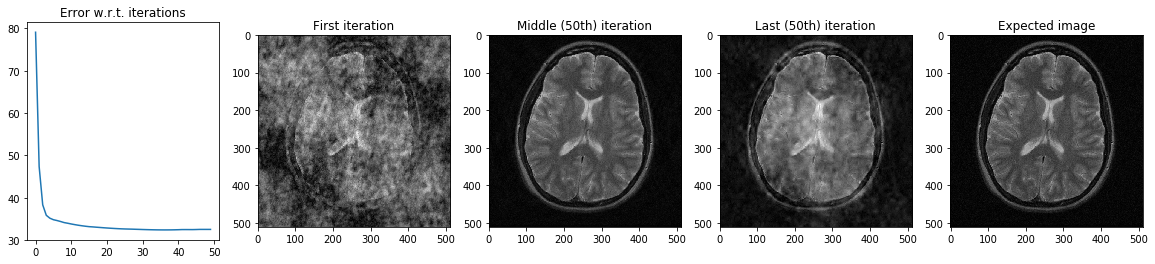

In [49]:
mask = brain_mat['mask_vardens']
y = np.multiply(np.fft.fft2(brain_image), mask)

max_iter = 50
l = 0.01
mu = 1e-15
hist = nlcg(y, mask, l, max_iter, mu, alpha=0.05, beta=0.6)
errors = [np.linalg.norm(brain_image-e) for e in hist]
idx_middle = np.where(errors>np.max(errors)/np.e)[0][-1]

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
ax1.plot(errors)
ax1.set_title('Error w.r.t. iterations')
ax2.imshow(np.abs(hist[0]), cmap='gray')
ax2.set_title('First iteration')
ax3.imshow(np.abs(history[idx_middle]), cmap='gray')
ax3.set_title('Middle (%dth) iteration'%(idx_middle+1))
ax4.imshow(np.abs(hist[-1]), cmap='gray')
ax4.set_title('Last (%dth) iteration'%(max_iter))
ax5.imshow(brain_image, cmap='gray')
ax5.set_title('Expected image')
plt.show()

# IV. Reconstruction with 1D Mask

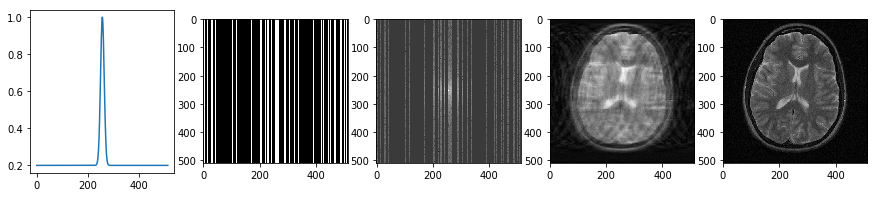

In [37]:
def normal_pdf(length, ivar):
    return np.exp(-ivar * (np.arange(length) - length / 2)**2)

img = np.abs(brain_mat['im'])
raw = np.fft.fft2(img)
raw = np.fft.fftshift(raw)

size = img.shape[0]
pdf = normal_pdf(size, 1e-2) / 1.25 + 0.20
xs = np.random.binomial(1, pdf)
mask = np.ones(img.shape)
mask = np.multiply(mask, xs)

masked_raw = np.multiply(raw, xs)
masked_img = np.fft.ifft2(masked_raw)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].plot(pdf)
axs[1].imshow(mask,cmap='gray')
axs[2].imshow(np.log10(np.abs(raw)**2)*mask, cmap='gray')
axs[3].imshow(np.abs(masked_img), cmap='gray')
axs[4].imshow(img, cmap='gray')

Text(0.5,1,'wavelet coefficients')

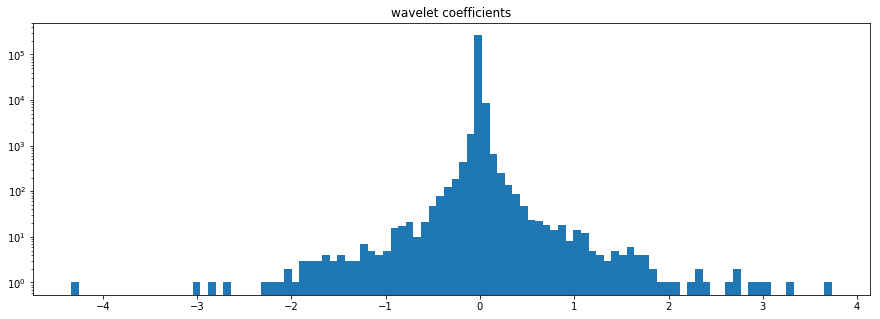

In [33]:
image_wt = pywt.wavedec2(np.abs(masked_img), wavelet)
all_coef = []
for e in image_wt[1:]:
    for i in range(3):
        all_coef.append(e[i].flatten())
        
full_coef = np.hstack(all_coef)
plt.figure(figsize=(15,5))
plt.hist(full_coef, log=True, bins=100)
plt.title('wavelet coefficients')

In [54]:
num_iter = 50
lambda_value = 0.05

# fftshift not necessary
masked_raw = np.multiply(np.fft.fft2(brain_image), 1-mask)

# Projection Over a Convex Set
hist_pocs = pocs(masked_raw, 1-mask, max_iter, lambda_value)

# Non-linear Conjugate-Gradient
hist_nlcg = nlcg(masked_raw, 1-mask, lambda_value, max_iter, mu=1e-15, alpha=0.05, beta=0.6)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


In [61]:
# plots
def show_history(hist):
    errors = [np.linalg.norm(brain_image-e) for e in hist]
    plt.figure(figsize=(12,3))
    plt.stem(errors)
    plt.title('Error w.r.t. iterations')
    plt.show()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
    ax1.imshow(np.abs(masked_img), cmap='gray')
    ax1.set_title('Masked image')
    ax2.imshow(np.abs(history[0]), cmap='gray')
    ax2.set_title('First iteration')
    ax3.imshow(np.abs(history[-1]), cmap='gray')
    ax3.set_title('Last(%dth) iteration'%(num_iter))
    ax4.imshow(brain_image, cmap='gray')
    ax4.set_title('Expected image')
    plt.show()

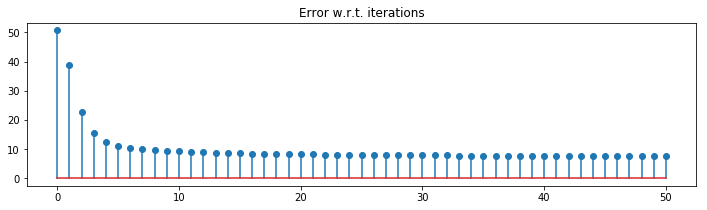

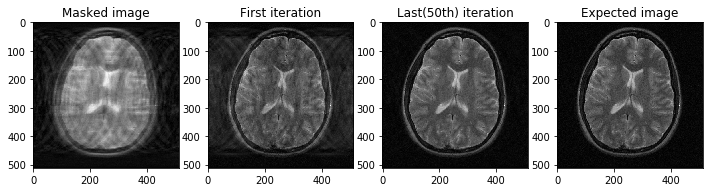

In [62]:
show_history(hist_pocs)

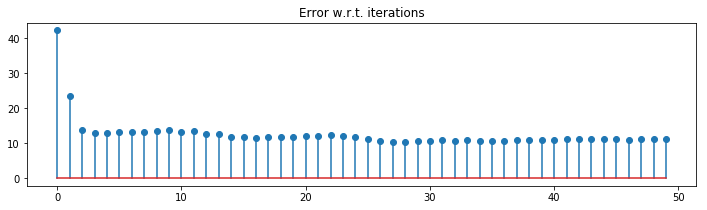

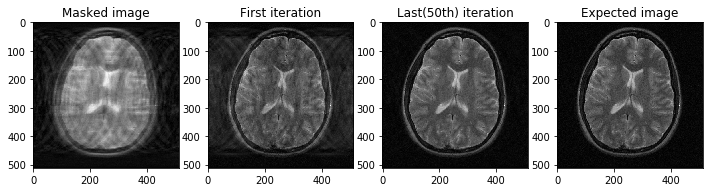

In [63]:
show_history(hist_nlcg)